In [3]:
import gsw
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
from scipy.io import loadmat
import os
import pandas as pd

In [5]:
def preprocess(ds):
    ds = ds.drop(['CHI-T']).squeeze()
    _, index = np.unique(ds.DEPTH, return_index=True)
    ds = ds.isel(DEPTH=index)
    index = ~np.isnan(ds.DEPTH)
    ds = ds.isel(DEPTH=index)

    ds = ds.expand_dims({'CAST': [np.int64(ds.attrs['cast_number'])]})
    
    DEPTH = xr.DataArray(np.arange(2000.,6500., 5.), coords={'DEPTH': np.arange(2000.,6500., 5.)}, dims=['DEPTH'])
    return ds.interp(DEPTH=DEPTH)

microstructure = xr.open_mfdataset("../../data/bbtre97_microstructure/bbtre*.nc", preprocess=preprocess, concat_dim=['CAST'])

<ipython-input-5-f1463abbaa17>:13: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  microstructure = xr.open_mfdataset("../../data/bbtre97_microstructure/bbtre*.nc", preprocess=preprocess, concat_dim=['CAST'])
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively

ValueError: conflicting sizes for dimension 'concat_dim': length 1 on 'concat_dim' and length 80 on 'LATITUDE'

In [ ]:
microstructure

In [38]:
casts = [filename for filename in os.listdir("../../data/DataForXiaozhou/ctd/full/") if ".mat" in filename]
in_canyon_casts = np.arange(7, 28)

df = pd.DataFrame()
for cast in casts:
    data = loadmat(f"../../data/DataForXiaozhou/ctd/full/{cast}")

    salinity = np.nanmean(np.concatenate((data['s1'], data['s2']), axis=1), axis=1)
    temperature = np.nanmean(np.concatenate((data['t1'], data['t2']), axis=1), axis=1)
    
    # Basic quality control for obvious (abyssal ocean) outliers
    mask = (np.abs(salinity - 34.9) > 0.5) | (np.abs(temperature - 2.) > 4.)
    salinity[mask] = np.nan
    temperature[mask] = np.nan
    
    pressure = data['pr'].squeeze()
    sigma4 = gsw.sigma4(salinity, gsw.CT_from_t(salinity, temperature, pressure))
    
    bottom_pressure = max(data['BottomP'], data['Maxp'], np.max(pressure)).squeeze()
    if np.isnan(bottom_pressure): continue
    
    tmp = pd.DataFrame({
        'cast number': data['castnum'].squeeze(),
        'in canyon': data['castnum'].squeeze() in in_canyon_casts,
        'bottom pressure': bottom_pressure,
        'latitude': -data['Lat'].squeeze(),
        'longitude': -data['Lon'].squeeze(),
        'pressure': pressure,
        'salinity': salinity,
        'temperature': temperature,
        'sigma4': sigma4,
    })
    
    df = df.append(tmp)

In [44]:
g = 9.81
ρ0 = 1035.

def bin_average(var, var_lev, lev_bounds):
    n_av = len(lev_bounds)-1
    var_av = np.zeros(n_av)
    for k in range(n_av):
        idx = (var_lev >= lev_bounds[k]) & (var_lev < lev_bounds[k+1])
        if sum(~np.isnan(var[idx])) > 20:
            var_av[k] = np.nanmean(var[idx])
        else:
            var_av[k] = np.nan
    return var_av

dp = 50.
pmin = 2000.
pmax = 6500.
new_pressure_f = np.arange(pmin-dp/2., pmax+dp/2, dp)
new_pressure = np.arange(pmin, pmax, dp)

cdf = pd.DataFrame()
for castnum in np.sort(df['cast number'].unique()):
    cast_df = df[df['cast number'] == castnum]
    tmp = pd.DataFrame({
        'cast number': castnum,
        'in canyon': castnum in in_canyon_casts,
        'bottom pressure': bin_average(cast_df['bottom pressure'], cast_df['pressure'], new_pressure_f),
        'latitude': bin_average(cast_df['latitude'], cast_df['pressure'], new_pressure_f),
        'longitude': bin_average(cast_df['longitude'], cast_df['pressure'], new_pressure_f),
        'pressure': new_pressure,
        'salinity': bin_average(cast_df['salinity'], cast_df['pressure'], new_pressure_f),
        'temperature': bin_average(cast_df['temperature'], cast_df['pressure'], new_pressure_f),
        'sigma4': bin_average(cast_df['sigma4'], cast_df['pressure'], new_pressure_f),
    })
    
    tmp['pressure_f'] = 0.5*(tmp['pressure'][0:-1] + tmp['pressure'][1:])
    tmp['Nsq'] = np.concatenate([g/ρ0 * np.diff(tmp['sigma4']) / np.diff(tmp['pressure']), np.array([np.nan])])
    
    cdf = cdf.append(tmp)
    
dp = 50.
pmin = -3000.
pmax = 0.
new_pressure_f = np.arange(pmin-dp/2., pmax+dp/2, dp)
new_pressure = np.arange(pmin, pmax, dp)

hdf = pd.DataFrame()
for castnum in np.sort(df['cast number'].unique()):
    cast_df = df[df['cast number'] == castnum]
    pressure_above_bottom = cast_df['pressure'] - cast_df['bottom pressure']
    tmp = pd.DataFrame({
        'cast number': castnum,
        'in canyon': castnum in in_canyon_casts,
        'bottom pressure': bin_average(cast_df['bottom pressure'], pressure_above_bottom, new_pressure_f),
        'latitude': bin_average(cast_df['latitude'], pressure_above_bottom, new_pressure_f),
        'longitude': bin_average(cast_df['longitude'], pressure_above_bottom, new_pressure_f),
        'pressure above bottom': new_pressure,
        'salinity': bin_average(cast_df['salinity'], pressure_above_bottom, new_pressure_f),
        'temperature': bin_average(cast_df['temperature'], pressure_above_bottom, new_pressure_f),
        'sigma4': bin_average(cast_df['sigma4'], pressure_above_bottom, new_pressure_f),
    })
    
    tmp['pressure_f above bottom'] = 0.5*(tmp['pressure above bottom'][0:-1] + tmp['pressure above bottom'][1:])
    tmp['Nsq'] = np.concatenate([g/ρ0 * np.diff(tmp['sigma4']) / np.diff(tmp['pressure above bottom']), np.array([np.nan])])
    
    hdf = hdf.append(tmp)

### Pressure coordinates

(0.0, 3e-06)

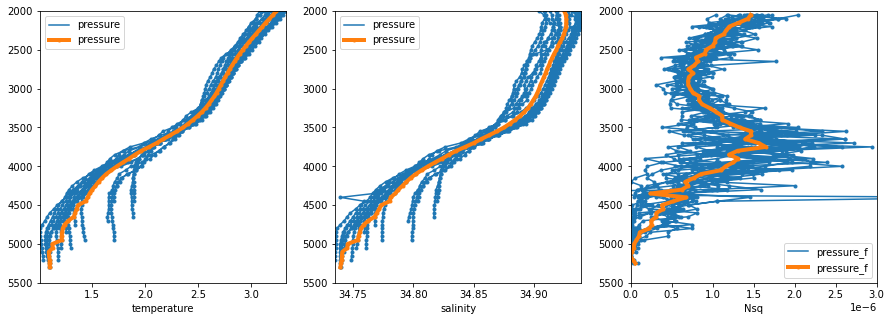

In [46]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
cdf[cdf['in canyon'] == True].plot(x='temperature', y='pressure',marker='.', ax=axes[0])
cdf[cdf['in canyon'] == True].groupby('pressure').mean().reset_index().plot(x='temperature', y='pressure',marker='.', color='C1', lw=4, ax=axes[0])

cdf[cdf['in canyon'] == True].plot(x='salinity', y='pressure',marker='.', ax=axes[1])
cdf[cdf['in canyon'] == True].groupby('pressure').mean().reset_index().plot(x='salinity', y='pressure',marker='.', color='C1', lw=4, ax=axes[1])

cdf[cdf['in canyon'] == True].plot(x='Nsq', y='pressure_f',marker='.', ax=axes[2])
cdf[cdf['in canyon'] == True].groupby('pressure_f').mean().reset_index().plot(x='Nsq', y='pressure_f',marker='.', color='C1', lw=4, ax=axes[2])

for ax in axes:
    ax.set_ylim([5500,2000])
axes[2].set_xlim([0., 3.e-6])

### Pressure-above-bottom coordinates

(0.0, 3e-06)

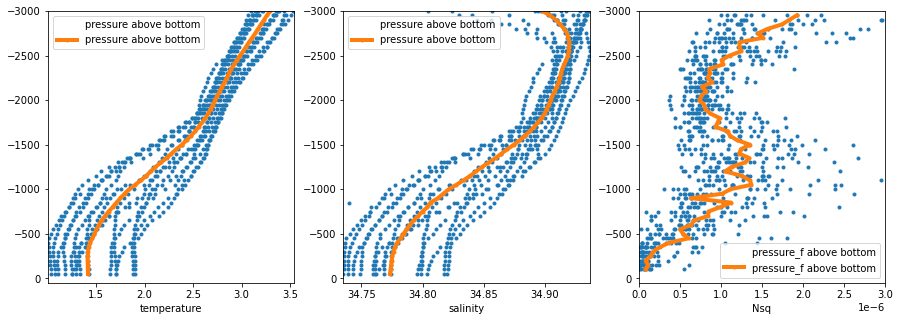

In [47]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
hdf[hdf['in canyon'] == True].plot(x='temperature', y='pressure above bottom', lw=0., marker='.', ax=axes[0])
hdf[hdf['in canyon'] == True].groupby('pressure above bottom').mean().reset_index().plot(x='temperature', y='pressure above bottom',marker='.', color='C1', lw=4, ax=axes[0])

hdf[hdf['in canyon'] == True].plot(x='salinity', y='pressure above bottom', lw=0., marker='.', ax=axes[1])
hdf[hdf['in canyon'] == True].groupby('pressure above bottom').mean().reset_index().plot(x='salinity', y='pressure above bottom',marker='.', color='C1', lw=4, ax=axes[1])


hdf[hdf['in canyon'] == True].plot(x='Nsq', y='pressure_f above bottom', lw=0., marker='.', ax=axes[2])
hdf[hdf['in canyon'] == True].groupby('pressure_f above bottom').mean().reset_index().plot(x='Nsq', y='pressure_f above bottom',marker='.', color='C1', lw=4, ax=axes[2])

for ax in axes:
    ax.set_ylim([50,-3000])
axes[2].set_xlim([0., 3.e-6])

In [48]:
hdf.head()

,cast number,in canyon,bottom pressure,latitude,longitude,pressure above bottom,salinity,temperature,sigma4,pressure_f above bottom,Nsq
0,10,True,5233.94,-21.784167,-19.4215,-3000.0,34.935204,3.148965,45.597848,NaN,0.000001
1,10,True,5233.94,-21.784167,-19.4215,-2950.0,34.933760,3.115585,45.604072,-2950.0,0.000001
2,10,True,5233.94,-21.784167,-19.4215,-2900.0,34.932982,3.089895,45.609357,-2900.0,0.000001
3,10,True,5233.94,-21.784167,-19.4215,-2850.0,34.931132,3.056363,45.615290,-2850.0,0.000001
4,10,True,5233.94,-21.784167,-19.4215,-2800.0,34.929147,3.019005,45.621836,-2800.0,0.000001


In [49]:
df.to_csv("../../data/BBTRE_hydrography_full.csv")
cdf.to_csv("../../data/BBTRE_hydrography_z-binned.csv")
hdf.to_csv("../../data/BBTRE_hydrography_hab-binned.csv")